#### **Find the emission pathways that caused the change in air quality over 2015-2017 in China**
- Per gridcell (emulator).  
- Remove the inputs that don't predict the correct change.  

##### **Steps**

*Calculated on HPC using `find_emissions_that_caused_air_quality_change.py` and `find_emissions_that_caused_air_quality_change.bash`.*

1. Load observations for 1 station.  
2. Find the change in measured PM2.5 (annual-mean) and O3 (6mDM8h) concentrations for this location over 2015-2017.  
3. Filter through predictions of all emission configurations for this location. 
4. Keep emission configurations where the prediction matchs (within 1%) the measured change in PM2.5/O3 concentrations.  

*Calculated in this notebook.*

5. Split by region.  
6. Compare to bottom-up estimates.  

___

In [1]:
import glob
import tabula
import joblib
from itertools import islice
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import re
import itertools
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'axes.grid': False,
    'savefig.dpi': 700,
    'font.size': 12,
    'text.usetex': True,
    'figure.figsize': [5, 5],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

___

In [2]:
### bottom up emissions 2015-2017 - Zheng et al., 2018 ACP
df = tabula.read_pdf('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/zheng2018.pdf', pages=7)
df.drop(columns=['Unnamed: 2', 'Unnamed: 4', 'Unnamed: 9', 'c'], inplace=True)
df.columns = ['sector', 'so2', 'nox', 'nmvoc', 'nh3', 'co', 'tsp', 'pm10', 'pm25', 'bc', 'oc', 'co2']

df_2010 = df.iloc[0:7].copy()
df_2011 = df.iloc[7:14].copy()
df_2012 = df.iloc[14:21].copy()
df_2013 = df.iloc[21:28].copy()
df_2014 = df.iloc[28:35].copy()
df_2015 = df.iloc[35:42].copy()
df_2016 = df.iloc[42:49].copy()
df_2017 = df.iloc[49:56].copy()

df_2010.set_index('sector', inplace=True)
df_2011.set_index('sector', inplace=True)
df_2012.set_index('sector', inplace=True)
df_2013.set_index('sector', inplace=True)
df_2014.set_index('sector', inplace=True)
df_2015.set_index('sector', inplace=True)
df_2016.set_index('sector', inplace=True)
df_2017.set_index('sector', inplace=True)

df_2010 = df_2010.astype('float32').copy()
df_2011 = df_2011.astype('float32').copy()
df_2012 = df_2012.astype('float32').copy()
df_2013 = df_2013.astype('float32').copy()
df_2014 = df_2014.astype('float32').copy()
df_2015 = df_2015.astype('float32').copy()
df_2016 = df_2016.astype('float32').copy()
df_2017 = df_2017.astype('float32').copy()

df_diff = ((100 * df_2017 / df_2015) - 100).copy()
df_diff.drop(['2015', '2017'], inplace=True)
df_diff

,so2,nox,nmvoc,nh3,co,tsp,pm10,pm25,bc,oc,co2
sector,,,,,,,,,,,
Agriculture,NaN,NaN,NaN,-1.030922,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Industry,-38.775513,-5.154640,3.191490,-25.000000,-12.455521,-29.299362,-22.388054,-20.454544,-25.000000,-25.0,-5.302750
Power,-53.846153,-17.647064,0.000000,NaN,6.666672,0.000000,0.000000,0.000000,NaN,NaN,9.054749
Residential,-17.241379,-11.111107,-14.285713,-25.000000,-10.937500,-15.909096,-17.073166,-16.666664,-14.285706,-15.0,3.837296
Solvent use,NaN,NaN,9.473686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transportation,0.000000,-3.750000,-11.111107,NaN,-12.802765,20.000008,20.000008,0.000000,0.000000,0.0,5.469841


In [12]:
df_diff_2010vs2015 = ((100 * df_2010 / df_2015) - 100).copy()
df_diff_2010vs2015.drop(['2015', '2010'], inplace=True)
zhang2018_bottomup20152010_allspecies_res = 1 + (df_diff_2010vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152010_allspecies_ind = 1 + (df_diff_2010vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152010_allspecies_tra = 1 + (df_diff_2010vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152010_allspecies_agr = 1 + (df_diff_2010vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152010_allspecies_ene = 1 + (df_diff_2010vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2010 vs 2015')
print(f'RES{zhang2018_bottomup20152010_allspecies_res:.2f}_IND{zhang2018_bottomup20152010_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152010_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152010_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152010_allspecies_ene:.2f}')
print()

df_diff_2011vs2015 = ((100 * df_2011 / df_2015) - 100).copy()
df_diff_2011vs2015.drop(['2015', '2011'], inplace=True)
zhang2018_bottomup20152011_allspecies_res = 1 + (df_diff_2011vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152011_allspecies_ind = 1 + (df_diff_2011vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152011_allspecies_tra = 1 + (df_diff_2011vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152011_allspecies_agr = 1 + (df_diff_2011vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152011_allspecies_ene = 1 + (df_diff_2011vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2011 vs 2015')
print(f'RES{zhang2018_bottomup20152011_allspecies_res:.2f}_IND{zhang2018_bottomup20152011_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152011_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152011_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152011_allspecies_ene:.2f}')
print()

df_diff_2012vs2015 = ((100 * df_2012 / df_2015) - 100).copy()
df_diff_2012vs2015.drop(['2015', '2012'], inplace=True)
zhang2018_bottomup20152012_allspecies_res = 1 + (df_diff_2012vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152012_allspecies_ind = 1 + (df_diff_2012vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152012_allspecies_tra = 1 + (df_diff_2012vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152012_allspecies_agr = 1 + (df_diff_2012vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152012_allspecies_ene = 1 + (df_diff_2012vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2012 vs 2015')
print(f'RES{zhang2018_bottomup20152012_allspecies_res:.2f}_IND{zhang2018_bottomup20152012_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152012_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152012_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152012_allspecies_ene:.2f}')
print()

df_diff_2013vs2015 = ((100 * df_2013 / df_2015) - 100).copy()
df_diff_2013vs2015.drop(['2015', '2013'], inplace=True)
zhang2018_bottomup20152013_allspecies_res = 1 + (df_diff_2013vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152013_allspecies_ind = 1 + (df_diff_2013vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152013_allspecies_tra = 1 + (df_diff_2013vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152013_allspecies_agr = 1 + (df_diff_2013vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152013_allspecies_ene = 1 + (df_diff_2013vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2013 vs 2015')
print(f'RES{zhang2018_bottomup20152013_allspecies_res:.2f}_IND{zhang2018_bottomup20152013_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152013_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152013_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152013_allspecies_ene:.2f}')
print()

df_diff_2014vs2015 = ((100 * df_2014 / df_2015) - 100).copy()
df_diff_2014vs2015.drop(['2015', '2014'], inplace=True)
zhang2018_bottomup20152014_allspecies_res = 1 + (df_diff_2014vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152014_allspecies_ind = 1 + (df_diff_2014vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152014_allspecies_tra = 1 + (df_diff_2014vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152014_allspecies_agr = 1 + (df_diff_2014vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152014_allspecies_ene = 1 + (df_diff_2014vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2014 vs 2015')
print(f'RES{zhang2018_bottomup20152014_allspecies_res:.2f}_IND{zhang2018_bottomup20152014_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152014_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152014_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152014_allspecies_ene:.2f}')
print()

df_diff_2016vs2015 = ((100 * df_2016 / df_2015) - 100).copy()
df_diff_2016vs2015.drop(['2015', '2016'], inplace=True)
zhang2018_bottomup20152016_allspecies_res = 1 + (df_diff_2016vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152016_allspecies_ind = 1 + (df_diff_2016vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152016_allspecies_tra = 1 + (df_diff_2016vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152016_allspecies_agr = 1 + (df_diff_2016vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152016_allspecies_ene = 1 + (df_diff_2016vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2016 vs 2015')
print(f'RES{zhang2018_bottomup20152016_allspecies_res:.2f}_IND{zhang2018_bottomup20152016_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152016_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152016_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152016_allspecies_ene:.2f}')
print()

df_diff_2017vs2015 = ((100 * df_2017 / df_2015) - 100).copy()
df_diff_2017vs2015.drop(['2015', '2017'], inplace=True)
zhang2018_bottomup20152017_allspecies_res = 1 + (df_diff_2017vs2015.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_ind = 1 + (df_diff_2017vs2015.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_tra = 1 + (df_diff_2017vs2015.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_agr = 1 + (df_diff_2017vs2015.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_ene = 1 + (df_diff_2017vs2015.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
print('2017 vs 2015')
print(f'RES{zhang2018_bottomup20152017_allspecies_res:.2f}_IND{zhang2018_bottomup20152017_allspecies_ind:.2f}_TRA{zhang2018_bottomup20152017_allspecies_tra:.2f}_AGR{zhang2018_bottomup20152017_allspecies_agr:.2f}_ENE{zhang2018_bottomup20152017_allspecies_ene:.2f}')
print()

2010 vs 2015
RES1.15_IND1.27_TRA0.98_AGR0.98_ENE1.36

2011 vs 2015
RES1.19_IND1.30_TRA1.01_AGR1.01_ENE1.46

2012 vs 2015
RES1.20_IND1.30_TRA1.01_AGR1.02_ENE1.39

2013 vs 2015
RES1.13_IND1.29_TRA1.02_AGR1.01_ENE1.29

2014 vs 2015
RES1.06_IND1.12_TRA0.99_AGR1.01_ENE1.12

2016 vs 2015
RES0.92_IND0.84_TRA0.97_AGR0.99_ENE0.94

2017 vs 2015
RES0.84_IND0.81_TRA0.99_AGR0.99_ENE0.89



___

In [ ]:
obs_files = glob.glob('/nfs/a68/earlacoa/china_measurements_corrected/*.nc')

df_obs = pd.read_csv(
    '/nfs/a68/earlacoa/china_measurements_corrected/df_obs_o3_6mDM8h_ppb_PM2_5_DRY.csv',
    index_col='datetime',
    parse_dates=True
)
df_obs

In [ ]:
outputs = ['o3_6mDM8h_ppb', 'PM2_5_DRY']

path_predictions = '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/predictions'

matrix_stacked = np.array(np.meshgrid(
    np.linspace(0.3, 1.3, 6), # np.linspace(0.2, 1.3, 12) for 10% intervals
    np.linspace(0.3, 1.3, 6), # np.linspace(0.3, 1.3, 6) for 20% intervals
    np.linspace(0.3, 1.3, 6), # removing edges of parameter space 0.0, 0.1, 1.4, 1.5
    np.linspace(0.3, 1.3, 6),
    np.linspace(0.3, 1.3, 6)
)).T.reshape(-1, 5)

obs_change_abs = {}
obs_change_per = {}
baselines = {}
targets = {}
station_diffs_abs = {}
station_diffs_per = {}

In [ ]:
for output in outputs:
    for obs_file in obs_files:
        station_id = obs_file[47:-3]
        lat = df_obs.loc[df_obs.station_id == station_id].station_lat.unique()[0]
        lon = df_obs.loc[df_obs.station_id == station_id].station_lon.unique()[0]
        
        change_per = 100 * ((df_obs.loc[df_obs.station_id == station_id][output]['2017'].values[0] / \
                             df_obs.loc[df_obs.station_id == station_id][output]['2015'].values[0]) - 1)
        change_abs = df_obs.loc[df_obs.station_id == station_id][output]['2017'].values[0] - \
                     df_obs.loc[df_obs.station_id == station_id][output]['2015'].values[0]

        obs_change_abs.update({f'{station_id}_{output}': change_abs})
        obs_change_per.update({f'{station_id}_{output}': change_per})

        if output == 'o3_6mDM8h_ppb':
            emulator_output = 'o3_6mDM8h'
        else:
            emulator_output = output
            
        with xr.open_dataset(
            f'{path_predictions}/{emulator_output}/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_{emulator_output}_popgrid_0.25deg.nc'
        )[emulator_output] as ds:
            baseline = ds.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest').values
                    
        baselines.update({f'{station_id}_{output}': baseline})

        target_abs = baseline + change_abs
        target_per = baseline * (1 + (change_per / 100))
        target = np.mean([target_abs, target_per])
        targets.update({f'{station_id}_{output}': target})
        
        target_diffs_abs = {}
        target_diffs_per = {}
        
        for matrix in matrix_stacked:
            inputs = matrix.reshape(-1, 5)        
            filename = f'RES{inputs[0][0]:.1f}_IND{inputs[0][1]:.1f}_TRA{inputs[0][2]:.1f}_AGR{inputs[0][3]:.1f}_ENE{inputs[0][4]:.1f}'
            with xr.open_dataset(
                f'{path_predictions}/{emulator_output}/ds_{filename}_{emulator_output}_popgrid_0.25deg.nc'
            )[emulator_output] as ds:
                prediction = ds.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest').values

            target_diff_abs = targets[f'{station_id}_{output}'] - prediction
            target_diff_per = (100 * (prediction / targets[f'{station_id}_{output}'])) - 100
            
            if abs(target_diff_per) < 1: # +/- 1% of target
                target_diffs_abs.update({filename: target_diff_abs})
                target_diffs_per.update({filename: target_diff_per})

        station_diffs_abs.update({f'{station_id}_{output}': target_diffs_abs})
        station_diffs_per.update({f'{station_id}_{output}': target_diffs_per})

In [ ]:
# for key in [key for key in targets.keys()]:
#     if np.isnan(targets[key]):
#         del targets[key]

In [ ]:
target_diffs = {}
for key in [key for key in targets.keys()]:
    target_diffs.update({key: targets[key] - baselines[key]})

In [ ]:
# for key in list(set([key for key in emulators.keys()]) - set([key for key in targets.keys()])):
#     del emulators[key]

In [ ]:
keys = [list(station_diffs_per[station].keys())for station in station_diffs_per.keys()]
keys_flatten = [item for sublist in keys for item in sublist]
keys_unique = {}
for key in keys_flatten:
    if key not in keys_unique:
        keys_unique.update({key: 1})
    elif key in keys_unique:
        keys_unique.update({key: keys_unique[key] + 1})

In [ ]:
path = '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/2015-2017_20percentintervals'

joblib.dump(targets, f'{path}/targets.joblib')
joblib.dump(baselines, f'{path}/baselines.joblib')
joblib.dump(target_diffs, f'{path}/target_diffs.joblib')
joblib.dump(obs_change_abs, f'{path}/obs_change_abs.joblib')
joblib.dump(obs_change_per, f'{path}/obs_change_per.joblib')
joblib.dump(keys_unique, f'{path}/keys_unique.joblib')
joblib.dump(station_diffs_per, f'{path}/station_diffs_per_1percent.joblib')
joblib.dump(station_diffs_abs, f'{path}/station_diffs_abs_1percent.joblib')

___

In [3]:
path = '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality'

files_targets = sorted(glob.glob(f'{path}/2015-2017_20percentintervals_scaled/targets*.joblib'))
files_baselines = sorted(glob.glob(f'{path}/2015-2017_20percentintervals_scaled/baselines*.joblib'))
files_target_diffs = sorted(glob.glob(f'{path}/2015-2017_20percentintervals_scaled/target_diffs*.joblib'))
files_station_diffs_per = sorted(glob.glob(f'{path}/2015-2017_20percentintervals_scaled/station_diffs_per*.joblib'))
files_station_diffs_abs = sorted(glob.glob(f'{path}/2015-2017_20percentintervals_scaled/station_diffs_abs*.joblib'))

In [5]:
targets = {}
baselines = {}
target_diffs = {}
station_diffs_per = {}
station_diffs_abs = {}

for index in range(len(files_targets)):
    if 'PM2_5_DRY' in files_target_diffs[index]:
        output = 'PM2_5_DRY'
    elif 'o3_6mDM8h' in files_target_diffs[index]:
        output = 'o3_6mDM8h'
        
    station_id = files_target_diffs[index][-12:-7]
    
    target = joblib.load(files_targets[index])
    baseline = joblib.load(files_baselines[index])
    target_diff = joblib.load(files_target_diffs[index])
    station_diff_per = joblib.load(files_station_diffs_per[index])
    station_diff_abs = joblib.load(files_station_diffs_abs[index])
    
    targets.update({f'{station_id}_{output}': target[[key for key in target.keys()][0]]})
    baselines.update({f'{station_id}_{output}': baseline[[key for key in baseline.keys()][0]]})
    target_diffs.update({f'{station_id}_{output}': target_diff[[key for key in target_diff.keys()][0]]})
    station_diffs_per.update({f'{station_id}_{output}': station_diff_per[[key for key in station_diff_per.keys()][0]]})
    station_diffs_abs.update({f'{station_id}_{output}': station_diff_abs[[key for key in station_diff_abs.keys()][0]]})

In [ ]:
#targets
#baselines
#target_diffs
#station_diffs_per
#station_diffs_abs

In [6]:
joblib.dump(targets, f'{path}/2015-2017_20percentintervals_scaled/targets_scaled.joblib')
joblib.dump(baselines, f'{path}/2015-2017_20percentintervals_scaled/baselines_scaled.joblib')
joblib.dump(target_diffs, f'{path}/2015-2017_20percentintervals_scaled/target_diffs_scaled.joblib')
joblib.dump(station_diffs_per, f'{path}/2015-2017_20percentintervals_scaled/station_diffs_per_scaled.joblib')
joblib.dump(station_diffs_abs, f'{path}/2015-2017_20percentintervals_scaled/station_diffs_abs_scaled.joblib')

['/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/2015-2017_20percentintervals_scaled/station_diffs_abs_scaled.joblib']

___

In [4]:
path = '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality'

targets = joblib.load(f'{path}/2015-2017_20percentintervals_scaled/targets_scaled.joblib')
baselines = joblib.load(f'{path}/2015-2017_20percentintervals_scaled/baselines_scaled.joblib')
target_diffs = joblib.load(f'{path}/2015-2017_20percentintervals_scaled/target_diffs_scaled.joblib')
station_diffs_per = joblib.load(f'{path}/2015-2017_20percentintervals_scaled/station_diffs_per_scaled.joblib')
station_diffs_abs = joblib.load(f'{path}/2015-2017_20percentintervals_scaled/station_diffs_abs_scaled.joblib')

In [8]:
regional_provinces = {
    'Beijing': 'North China',
    'Tianjin': 'North China',
    'Hebei': 'North China',
    'Shanxi': 'North China',
    'Nei Mongol': 'North China',
    'Liaoning': 'North East China',
    'Jilin': 'North East China',
    'Heilongjiang': 'North East China',
    'Shanghai': 'East China',
    'Jiangsu': 'East China',
    'Zhejiang': 'East China', 
    'Anhui': 'East China', 
    'Fujian': 'East China', 
    'Jiangxi': 'East China', 
    'Shandong': 'East China',
    'Taiwan': 'East China',
    'Henan': 'South Central China',
    'Hubei': 'South Central China',
    'Hunan': 'South Central China',
    'Guangdong': 'South Central China',
    'Guangxi': 'South Central China',
    'Hainan': 'South Central China',
    'Hong Kong': 'South Central China',
    'Macao': 'South Central China',
    'Chongqing': 'South West China',
    'Sichuan': 'South West China',
    'Guizhou': 'South West China',
    'Yunnan': 'South West China',
    'Xizang': 'South West China',
    'Shaanxi': 'North West China',
    'Gansu': 'North West China', 
    'Qinghai': 'North West China',
    'Ningxia Hui': 'North West China',
    'Xinjiang Uygur': 'North West China'
}

gba_prefectures = ['Dongguan', 'Foshan', 'Guangzhou', 'Huizhou', 'Jiangmen', 'Shenzhen', 'Zhaoqing', 'Zhongshan', 'Zhuhai', 'Hong Kong', 'Macao']

In [9]:
gdf_prefectures_china = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_3.shp')
gdf_prefectures_hongkong = gpd.read_file('/nfs/a68/earlacoa/shapefiles/hongkong/gadm36_HKG_1.shp')
gdf_prefectures_macao = gpd.read_file('/nfs/a68/earlacoa/shapefiles/macao/gadm36_MAC_2.shp')

list_prefectures_gba = []
for gba_prefecture in gba_prefectures:
    list_prefectures_gba.append(gdf_prefectures_china.loc[gdf_prefectures_china.NAME_2 == gba_prefecture])


list_prefectures_gba.append(gdf_prefectures_hongkong)
list_prefectures_gba.append(gdf_prefectures_macao)
    
gdf_prefectures_gba = pd.concat(list_prefectures_gba)

In [10]:
prefectures = {
    'North China': [],
    'North East China': [],
    'East China': [],
    'South Central China': [],
    'South West China': [],
    'North West China': [],
}
for prefecture in gdf_prefectures_china.NAME_2.unique():
    province = gdf_prefectures_china.loc[gdf_prefectures_china.NAME_2 == prefecture].NAME_1.unique()[0]
    region = regional_provinces[province]
    prefectures[region].append(prefecture)
    

for region, prefecture_list in prefectures.items():
    prefecture_list = list(set(prefecture_list))
    prefectures.update({region: prefecture_list})

In [11]:
regional_prefectures = {}
for region, prefecture_list in prefectures.items():
    prefecture_list = list(set(prefecture_list))
    for prefecture in prefecture_list:
        regional_prefectures.update({prefecture: region})

In [12]:
gdf_china_north = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_north.shp')
gdf_china_north_east = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_north_east.shp')
gdf_china_east = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_east.shp')
gdf_china_south_central = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_south_central.shp')
gdf_china_south_west = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_south_west.shp')
gdf_china_north_west = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/CHN_north_west.shp')

In [13]:
from shapely.geometry import Point

In [15]:
obs_lats = {}
obs_lons = {}
obs_prefectures = {}
obs_regions = {}
obs_gba = {}

obs_files = glob.glob('/nfs/a68/earlacoa/china_measurements_corrected/*.nc')

for obs_file in obs_files:
    with xr.open_dataset(obs_file) as ds:
        station_id = ds.station
        if '.nc' in station_id:
            station_id = station_id[:-3]
            
        obs_lats.update({station_id: ds.lat})
        obs_lons.update({station_id: ds.lon})
        obs_prefectures.update({station_id: ds.city})
        
        if gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_north).values[0]:
            region = 'North China'
        elif gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_north_east).values[0]:
            region = 'North East China'
        elif gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_east).values[0]:
            region = 'East China'
        elif gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_south_central).values[0]:
            region = 'South Central China'
        elif gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_south_west).values[0]:
            region = 'South West China'
        elif gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_north_west).values[0]:
            region = 'North West China'
            
        obs_regions.update({station_id: region})
        if (ds.city in gba_prefectures) or (ds.city == 'Hong Kong') or (ds.city == 'Macao'):
            obs_gba.update({station_id: True})
        else:
            obs_gba.update({station_id: False})

<ipython-input-15-02316a287c45>:19: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  if gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_north).values[0]:
<ipython-input-15-02316a287c45>:19: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  if gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_north).values[0]:
<ipython-input-15-02316a287c45>:19: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  if gpd.GeoSeries(Point(ds.lon, ds.lat)).within(gdf_china_north).values[0]:
<ipy

In [ ]:
# obs_lats = {}
# obs_lons = {}
# obs_prefectures = {}
# obs_regions = {}
# obs_gba = {}
  
# for obs_file in obs_files:
#     with xr.open_dataset(obs_file) as ds:
#         station_id = ds.station
#         if '.nc' in station_id:
#             station_id = station_id[:-3]
            
#         obs_lats.update({station_id: ds.lat})
#         obs_lons.update({station_id: ds.lon})
#         obs_prefectures.update({station_id: ds.city})
#         if ds.city == 'Lhasa Googut':
#             region = regional_prefectures['Lhasa']
#         elif ds.city == 'Huaian':
#             region = regional_prefectures["Huai'an"]
#         elif ds.city == 'Urumqi':
#             region = 'North West China'
#         elif ds.city == 'Ordos City':
#             region = regional_prefectures["Ordos"]
#         elif ds.city == 'Yingkou':
#             region = 'North East China'
#         elif ds.city == 'Sunlight':
#             region = 'East China'
#         elif ds.city == 'Iris':
#             region = 'South Central China'
#         elif ds.city == 'chicken':
#             region = 'South Central China'
#         elif ds.city == 'Mudan River':
#             region = 'North West China'
#         elif ds.city == 'Maanshan':
#             region = 'East China'
#         elif ds.city == 'North Sea':
#             region = 'South Central China'
#         elif ds.city == 'Yanan':
#             region = 'North China'
#         elif ds.city == 'Korla':
#             region = 'North West China'
#         elif ds.city == 'Shouguang':
#             region = 'East China'
#         elif ds.city == 'Zhang Qiu':
#             region = 'East China'
#         elif ds.city == 'Jimo':
#             region = 'East China'
#         elif ds.city == 'Jiaonan':
#             region = 'East China'
#         elif ds.city == 'Jiaozhou':
#             region = 'East China'
#         elif ds.city == 'Laixi':
#             region = 'East China'
#         elif ds.city == 'Pingdu':
#             region = 'East China'
#         elif ds.city == 'Penglai':
#             region = 'East China'
#         else:
#             region = regional_prefectures[ds.city]
            
#         obs_regions.update({station_id: region})
#         if (ds.city in gba_prefectures) or (ds.city == 'Hong Kong') or (ds.city == 'Macao'):
#             obs_gba.update({station_id: True})
#         else:
#             obs_gba.update({station_id: False})

In [9]:
regions = ['China', 'GBA', 'North China', 'North East China', 'East China', 'South Central China', 'South West China', 'North West China']
region_stations = {key: [] for key in regions}

for station_id, station_region in obs_regions.items():
    region_stations['China'].append(station_id)
    region_stations[station_region].append(station_id)
    
    if obs_gba[station_id] == True:
        region_stations['GBA'].append(station_id)

NameError: name 'obs_regions' is not defined

In [17]:
regional_targets = {}
regional_baselines = {}
regional_target_diffs = {}
regional_station_diffs_per = {}
regional_station_diffs_abs = {}

for region in regions:
    regional_targets.update({region: dict((key, value) for key, value in targets.items() if key[0:5] in region_stations[region])})
    regional_baselines.update({region: dict((key, value) for key, value in baselines.items() if key[0:5] in region_stations[region])})
    regional_target_diffs.update({region: dict((key, value) for key, value in target_diffs.items() if key[0:5] in region_stations[region])})
    regional_station_diffs_per.update({region: dict((key, value) for key, value in station_diffs_per.items() if key[0:5] in region_stations[region])})
    regional_station_diffs_abs.update({region: dict((key, value) for key, value in station_diffs_abs.items() if key[0:5] in region_stations[region])})

In [18]:
outputs = ['PM2_5_DRY', 'o3_6mDM8h', 'combined']

regional_keys_unique_sorted = {}
regional_target_diffs_under0p5 = {}

for output in outputs:
    for region in regions:
        if output == 'combined':
            keys = [list(regional_station_diffs_per[region][stationid_output].keys()) for stationid_output in regional_station_diffs_per[region].keys()]
        else:
            keys = [list(regional_station_diffs_per[region][stationid_output].keys()) for stationid_output in regional_station_diffs_per[region].keys() if output in stationid_output]
            
        keys_flatten = [item for sublist in keys for item in sublist]

        keys_unique = {}
        for key in keys_flatten:
            if key not in keys_unique:
                keys_unique.update({key: 1})
            elif key in keys_unique:
                keys_unique.update({key: keys_unique[key] + 1})


        keys_unique_sorted = {key: value for key, value in sorted(keys_unique.items(), key=lambda item: item[1], reverse=True)}
        regional_keys_unique_sorted.update({f'{region}_{output}': keys_unique_sorted})

        target_diffs_under0p5 = {}
        for key, value in regional_target_diffs[region].items():
            if abs(value) < 0.5:
                target_diffs_under0p5.update({key: value})


        regional_target_diffs_under0p5.update({f'{region}_{output}': target_diffs_under0p5})

In [19]:
number_of_stations = {}
number_of_emission_configurations = {}
first_emission_configuration_keys = {}
second_emission_configuration_keys = {}
third_emission_configuration_keys = {}
first_emission_configuration_values = {}
second_emission_configuration_values = {}
third_emission_configuration_values = {}
number_of_stations_with_target_diff_under_0p5 = {}

for output in outputs:
    for region in regional_targets.keys():
        number_of_stations.update({f'{region}_{output}': len(regional_targets[region].keys())})
        number_of_emission_configurations.update({f'{region}_{output}': len(regional_keys_unique_sorted[f'{region}_{output}'].keys())})
        
        top3_emission_configurations = list(islice(regional_keys_unique_sorted[f'{region}_{output}'].items(), 3))
        
        first_emission_configuration_keys.update({f'{region}_{output}': top3_emission_configurations[0][0]})
        second_emission_configuration_keys.update({f'{region}_{output}': top3_emission_configurations[1][0]})
        third_emission_configuration_keys.update({f'{region}_{output}': top3_emission_configurations[2][0]})
        first_emission_configuration_values.update({f'{region}_{output}': top3_emission_configurations[0][1]})
        second_emission_configuration_values.update({f'{region}_{output}': top3_emission_configurations[1][1]})
        third_emission_configuration_values.update({f'{region}_{output}': top3_emission_configurations[2][1]})
        number_of_stations_with_target_diff_under_0p5.update({f'{region}_{output}': len(regional_target_diffs_under0p5[f'{region}_{output}'])})

In [20]:
df_regions = pd.concat([
    pd.Series(number_of_stations, name='Stations'),
    pd.Series(number_of_emission_configurations, name='Possible Emission Configurations'),
    pd.Series(first_emission_configuration_keys, name='First Emission Configuration - Key'),
    pd.Series(first_emission_configuration_values, name='First Emission Configuration - Value'),
    pd.Series(second_emission_configuration_keys, name='Second Emission Configuration - Key'),
    pd.Series(second_emission_configuration_values, name='Second Emission Configuration - Value'),
    pd.Series(third_emission_configuration_keys, name='Third Emission Configuration - Key'),
    pd.Series(third_emission_configuration_values, name='Third Emission Configuration - Value'),
    pd.Series(number_of_stations_with_target_diff_under_0p5, name='Stations with trend size under 0.5 ugm-3')
], axis=1)
df_regions

,Stations,Possible Emission Configurations,First Emission Configuration - Key,First Emission Configuration - Value,Second Emission Configuration - Key,Second Emission Configuration - Value,Third Emission Configuration - Key,Third Emission Configuration - Value,Stations with trend size under 0.5 ugm-3
China_PM2_5_DRY,3266,7745,RES1.0_IND0.8_TRA0.4_AGR0.8_ENE1.0,82,RES1.0_IND0.8_TRA0.6_AGR0.6_ENE1.2,82,RES1.2_IND0.6_TRA1.2_AGR0.8_ENE0.2,77,108
GBA_PM2_5_DRY,114,2685,RES0.6_IND1.2_TRA1.2_AGR1.0_ENE0.8,8,RES1.2_IND0.8_TRA0.8_AGR1.2_ENE0.2,7,RES1.0_IND0.8_TRA1.2_AGR1.2_ENE0.2,7,9
North China_PM2_5_DRY,410,6395,RES0.8_IND1.0_TRA1.2_AGR1.0_ENE1.0,15,RES0.8_IND1.0_TRA0.8_AGR1.2_ENE1.2,15,RES0.8_IND1.0_TRA1.0_AGR1.2_ENE0.8,14,15
North East China_PM2_5_DRY,342,6479,RES0.8_IND0.4_TRA1.2_AGR1.0_ENE1.0,18,RES0.8_IND0.4_TRA0.8_AGR1.2_ENE1.0,17,RES0.8_IND0.4_TRA1.0_AGR1.2_ENE0.8,16,9
East China_PM2_5_DRY,950,6343,RES1.2_IND0.8_TRA0.2_AGR0.8_ENE0.2,30,RES1.2_IND0.8_TRA0.4_AGR0.4_ENE0.2,27,RES1.0_IND0.8_TRA0.4_AGR0.8_ENE0.4,27,17
South Central China_PM2_5_DRY,772,5376,RES1.0_IND1.2_TRA0.6_AGR0.6_ENE0.2,34,RES1.2_IND1.2_TRA0.2_AGR0.4_ENE0.4,33,RES1.2_IND1.2_TRA0.2_AGR0.4_ENE0.8,33,31
South West China_PM2_5_DRY,458,6509,RES0.8_IND1.0_TRA0.8_AGR0.8_ENE0.6,21,RES0.8_IND1.0_TRA1.0_AGR0.8_ENE0.4,19,RES0.8_IND1.0_TRA1.0_AGR0.6_ENE1.0,19,25
North West China_PM2_5_DRY,334,6782,RES0.8_IND1.0_TRA1.2_AGR0.4_ENE0.8,15,RES1.0_IND1.0_TRA1.2_AGR0.4_ENE0.2,14,RES0.8_IND1.2_TRA0.8_AGR0.4_ENE0.4,14,11
China_o3_6mDM8h,3266,7776,RES1.2_IND1.2_TRA1.2_AGR1.0_ENE0.2,79,RES1.2_IND1.2_TRA1.2_AGR1.2_ENE0.2,79,RES1.0_IND0.6_TRA0.4_AGR0.8_ENE0.4,77,108
GBA_o3_6mDM8h,114,6750,RES1.0_IND1.2_TRA0.4_AGR0.2_ENE0.2,10,RES1.2_IND1.2_TRA0.4_AGR0.2_ENE0.2,10,RES1.0_IND1.2_TRA0.4_AGR0.4_ENE0.2,10,9


In [21]:
df_regions.to_csv(f'{path}/df_regions_scaled.csv')
joblib.dump(regional_keys_unique_sorted, f'{path}/regional_keys_unique_sorted_scaled.joblib')

['/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/find_emissions_that_match_change_air_quality/regional_keys_unique_sorted_scaled.joblib']

In [5]:
df_regions = pd.read_csv(f'{path}/df_regions_scaled.csv')
regional_keys_unique_sorted = joblib.load(f'{path}/regional_keys_unique_sorted_scaled.joblib')

In [6]:
def make_boxplot(index, values, sector, bottomup):
    ax = fig.add_subplot(gs[index])
    ax.set_facecolor('whitesmoke')
    plt.ylim([0.0, 1.5])
    plt.yticks(np.arange(0, 1.75, 0.25))
    ax.set_yticklabels(np.arange(0, 175, 25))
    plt.yticks(fontsize=14)
    ax.axes.get_xaxis().set_visible(False)
    if index == 0:
        plt.ylabel('Percentage emissions ({\%})', fontsize=14)
    else:
        ax.axes.get_yaxis().set_visible(False)
        
    plt.title(sector)
    color1 = '#c7eae5'
    color2 = '#01665e'
    plt.boxplot(
        values, 
        patch_artist=True,
        boxprops={'facecolor': color1, 'color': color2, 'linewidth': 1.5},
        capprops={'color': color2, 'linewidth': 1.5},
        whiskerprops={'color': color2, 'linewidth': 1.5},
        flierprops={'color': color2, 'markeredgecolor': color2, 'linewidth': 1.5},
        medianprops={'color': color2, 'linewidth': 1.5},
        showmeans=True,
        meanprops={'markeredgecolor': color2, 'color': color2},
        showfliers=False,
        whis=(5, 95),
        zorder=1
    )
    plt.scatter(1, bottomup, color='#8c510a', zorder=2, marker='*')
    plt.annotate(r'\textbf{(' + chr(97 + index) + ')}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14, weight='bold')

In [7]:
zhang2018_bottomup20152017_allspecies_res = 1 + (df_diff.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_ind = 1 + (df_diff.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_tra = 1 + (df_diff.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_agr = 1 + (df_diff.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_ene = 1 + (df_diff.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)

In [10]:
output = 'combined'

factors_all = {}

for region in regions:
    factors_res = {}
    factors_ind = {}
    factors_tra = {}
    factors_agr = {}
    factors_ene = {}
    for index, items in enumerate(list(itertools.islice(regional_keys_unique_sorted[f'{region}_{output}'].items(), 100))):
        factor_res, factor_ind, factor_tra, factor_agr, factor_ene = [float(item) for item in re.findall('\d+\.\d+',  items[0])]
        factors_res.update({index: factor_res})
        factors_ind.update({index: factor_ind})
        factors_tra.update({index: factor_tra})
        factors_agr.update({index: factor_agr})
        factors_ene.update({index: factor_ene})
        
    factors_all.update({f'{region}_RES': factors_res})
    factors_all.update({f'{region}_IND': factors_ind})
    factors_all.update({f'{region}_TRA': factors_tra})
    factors_all.update({f'{region}_AGR': factors_agr})
    factors_all.update({f'{region}_ENE': factors_ene})

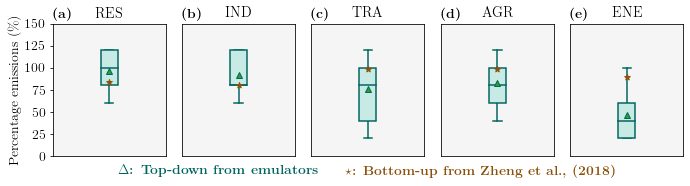

In [11]:
fig = plt.figure(1, figsize=(15, 3))
gs = gridspec.GridSpec(1, 5)

region = 'China'

make_boxplot(0, factors_all[f'{region}_RES'].values(), 'RES', zhang2018_bottomup20152017_allspecies_res)
make_boxplot(1, factors_all[f'{region}_IND'].values(), 'IND', zhang2018_bottomup20152017_allspecies_ind)
make_boxplot(2, factors_all[f'{region}_TRA'].values(), 'TRA', zhang2018_bottomup20152017_allspecies_tra)
make_boxplot(3, factors_all[f'{region}_AGR'].values(), 'AGR', zhang2018_bottomup20152017_allspecies_agr)
make_boxplot(4, factors_all[f'{region}_ENE'].values(), 'ENE', zhang2018_bottomup20152017_allspecies_ene)

gs.tight_layout(fig, rect=[0, 0, 0.65, 0.85])

plt.annotate(r'\textbf{$\Delta$: Top-down from emulators}', xy=(-4.0, -0.15), xycoords='axes fraction', fontsize=14, color='#01665e')
plt.annotate(r'\textbf{$\star$: Bottom-up from Zheng et al., (2018)}', xy=(-2.0, -0.15), xycoords='axes fraction', fontsize=14, color='#8c510a')

#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_factors_boxplot_top100_{region}_{output}_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig(f'/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_factors_boxplot_top100_{region}_{output}_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [27]:
baselines_mean = {}
targets_mean = {}
target_diffs_mean = {}

for output in ['PM2_5_DRY', 'o3_6mDM8h']:
    for region in regions:
        values = []
        for key, value in regional_baselines[region].items():
            if output in key and value is not np.nan:
                values.append(value)

        values = np.array(values)
        baselines_mean.update({f'{region}_{output}': np.nanmean(values)})

        values = []
        for key, value in regional_targets[region].items():
            if output in key and value is not np.nan:
                values.append(value)

        values = np.array(values)
        targets_mean.update({f'{region}_{output}': np.nanmean(values)})

        values = []
        for key, value in regional_target_diffs[region].items():
            if output in key and value is not np.nan:
                values.append(value)

        values = np.array(values)
        target_diffs_mean.update({f'{region}_{output}': np.nanmean(values)})

In [28]:
for output in ['PM2_5_DRY', 'o3_6mDM8h']:
    for region in regions:
        print(region, output)
        percent_change = (100 * ( baselines_mean[f'{region}_{output}'] + target_diffs_mean[f'{region}_{output}'] ) / baselines_mean[f'{region}_{output}']) - 100
        print(f"Baseline = {round(baselines_mean[f'{region}_{output}'], 1)}")
        print(f"Target = {round(targets_mean[f'{region}_{output}'], 1)}")
        #print(f"Absolute change = {round(target_diffs_mean[f'{region}_{output}'], 1)}")
        print(f"Percentage change = {round(percent_change, 1)} %")
        print()

China PM2_5_DRY
Baseline = 49.4
Target = 44.2
Percentage change = -9.5 %

GBA PM2_5_DRY
Baseline = 33.3
Target = 33.3
Percentage change = 0.5 %

North China PM2_5_DRY
Baseline = 55.9
Target = 51.1
Percentage change = -8.3 %

North East China PM2_5_DRY
Baseline = 50.9
Target = 41.1
Percentage change = -17.6 %

East China PM2_5_DRY
Baseline = 54.0
Target = 47.4
Percentage change = -10.6 %

South Central China PM2_5_DRY
Baseline = 53.1
Target = 46.3
Percentage change = -11.3 %

South West China PM2_5_DRY
Baseline = 34.9
Target = 31.7
Percentage change = -8.5 %

North West China PM2_5_DRY
Baseline = 41.2
Target = 43.7
Percentage change = 5.2 %

China o3_6mDM8h
Baseline = 45.4
Target = 52.8
Percentage change = 16.6 %

GBA o3_6mDM8h
Baseline = 44.2
Target = 48.5
Percentage change = 9.5 %

North China o3_6mDM8h
Baseline = 47.6
Target = 58.1
Percentage change = 21.4 %

North East China o3_6mDM8h
Baseline = 44.4
Target = 50.1
Percentage change = 13.3 %

East China o3_6mDM8h
Baseline = 46.9
Targ

In [29]:
print('RES', round(zhang2018_bottomup20152017_allspecies_res, 2))
print('IND', round(zhang2018_bottomup20152017_allspecies_ind, 2))
print('TRA', round(zhang2018_bottomup20152017_allspecies_tra, 2))
print('AGR', round(zhang2018_bottomup20152017_allspecies_agr, 2))
print('ENE', round(zhang2018_bottomup20152017_allspecies_ene, 2))

RES 0.84
IND 0.81
TRA 0.99
AGR 0.99
ENE 0.89


China
RES 0.96
IND 0.92
TRA 0.75
AGR 0.83
ENE 0.46

GBA
RES 0.92
IND 1.1
TRA 0.76
AGR 0.9
ENE 0.61

North China
RES 0.85
IND 0.92
TRA 0.94
AGR 0.84
ENE 0.52

North East China
RES 0.99
IND 0.53
TRA 0.67
AGR 0.64
ENE 0.54

East China
RES 1.05
IND 0.77
TRA 0.55
AGR 0.73
ENE 0.37

South Central China
RES 0.95
IND 1.1
TRA 0.76
AGR 0.64
ENE 0.65

South West China
RES 0.8
IND 0.97
TRA 0.9
AGR 0.83
ENE 0.72

North West China
RES 0.95
IND 0.99
TRA 0.83
AGR 0.6
ENE 0.7



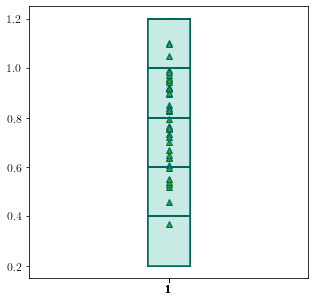

In [30]:
sectors = ['RES', 'IND', 'TRA', 'AGR', 'ENE']
color1 = '#c7eae5'
color2 = '#01665e'

for region in regions:
    print(region)
    for sector in sectors:
        bp = plt.boxplot(
            factors_all[f'{region}_{sector}'].values(), 
            patch_artist=True,
            boxprops={'facecolor': color1, 'color': color2, 'linewidth': 1.5},
            capprops={'color': color2, 'linewidth': 1.5},
            whiskerprops={'color': color2, 'linewidth': 1.5},
            flierprops={'color': color2, 'markeredgecolor': color2, 'linewidth': 1.5},
            medianprops={'color': color2, 'linewidth': 1.5},
            showmeans=True,
            meanprops={'markeredgecolor': color2, 'color': color2},
            showfliers=False,
            whis=(5, 95),
            zorder=1
        )
        print(sector, round(bp['means'][0].get_ydata()[0], 2))
    print()

### Plot - Health impact assessments

In [7]:
emission_config_filenames = {
    'bottom_up_2010vs2015': 'RES1.15_IND1.27_TRA0.98_AGR0.98_ENE1.36',
    'bottom_up_2011vs2015': 'RES1.19_IND1.30_TRA1.01_AGR1.01_ENE1.46',
    'bottom_up_2012vs2015': 'RES1.20_IND1.30_TRA1.01_AGR1.02_ENE1.39',
    'bottom_up_2013vs2015': 'RES1.13_IND1.29_TRA1.02_AGR1.01_ENE1.29',
    'bottom_up_2014vs2015': 'RES1.06_IND1.12_TRA0.99_AGR1.01_ENE1.12',
    'baseline': 'RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0',
    'bottom_up_2016vs2015': 'RES0.92_IND0.84_TRA0.97_AGR0.99_ENE0.94',
    'bottom_up_2017vs2015': 'RES0.84_IND0.81_TRA0.99_AGR0.99_ENE0.89',
    'top_down_2017vs2015': 'RES0.91_IND1.04_TRA0.88_AGR0.88_ENE0.52',
}

In [8]:
path_hia = f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/health_impact_assessments'

outputs = ['PM2_5_DRY', 'o3_6mDM8h']
outcomes = ['mort', 'dalys_rate']

sims_set = set(['RES', 'IND', 'TRA', 'AGR', 'ENE'])
labels_output = {
    'PM2_5_DRY': 'PM$_{2.5}$ exposure',
    'o3_6mDM8h': 'O$_3$ exposure',
}
labels = {
    'PM2_5_DRY_mort': 'MORT from PM$_{2.5}$ exposure ($deaths$ $y^{-1}$)',
    'PM2_5_DRY_dalys_rate': 'DALYS rate from PM$_{2.5}$ exposure ($DALYS$ $100,000$ $population^{-1}$ $y^{-1}$)',
    'o3_6mDM8h_mort': 'MORT from O$_3$ exposure ($deaths$ $y^{-1}$)',
    'o3_6mDM8h_dalys_rate': 'DALYS rate from O$_3$ exposure ($DALYS$ $100,000$ $population^{-1}$ $y^{-1}$)',
}
outcomes_mort = {
    'PM2_5_DRY': 'mort_ncdlri_mean_total',
    'o3_6mDM8h': 'mort_copd_mean_total',
}
outcomes_dalys_rate = {
    'PM2_5_DRY': 'dalys_rate_ncdlri_mean_total',
    'o3_6mDM8h': 'dalys_rate_copd_mean_total',
}
regions = {
    'North China': ['Beijing', 'Tianjin', 'Hebei', 'Shanxi', 'Nei Mongol'],
    'North East China': ['Liaoning', 'Jilin', 'Heilongjiang'],
    'East China': ['Shanghai', 'Jiangsu', 'Zhejiang', 'Anhui', 'Fujian', 'Jiangxi', 'Shandong'],
    'South Central China': ['Henan', 'Hubei', 'Hunan', 'Guangdong', 'Guangxi', 'Hainan'],
    'South West China': ['Chongqing', 'Sichuan', 'Guizhou', 'Yunnan', 'Xizang'],
    'North West China': ['Shaanxi', 'Gansu', 'Qinghai', 'Ningxia Hui', 'Xinjiang Uygur']
}
# GBA = Dongguan, Foshan, Guangzhou, Huizhou, Jiangmen, Shenzhen, Zhaoqing, Zhongshan, Zhuhai, Hong Kong, and Macao

regions_all = ['China', 'GBA'] + list(regions.keys())

In [9]:
results_compare = {}
outcomes_keys_compare = {
    'exposure_PM2_5_DRY_mean': 'pm25_popweighted',
    'exposure_o3_6mDM8h_mean': 'o3_popweighted',
    'mort_PM2_5_DRY_mean': 'mort_ncdlri_mean_total',
    'mort_o3_6mDM8h_mean': 'mort_copd_mean_total',
    'mort_PM2_5_DRY_lower': 'mort_ncdlri_lower_total',
    'mort_o3_6mDM8h_lower': 'mort_copd_lower_total',
    'mort_PM2_5_DRY_upper': 'mort_ncdlri_upper_total',
    'mort_o3_6mDM8h_upper': 'mort_copd_upper_total',
    'dalys_rate_PM2_5_DRY_mean': 'dalys_rate_ncdlri_mean_total',
    'dalys_rate_o3_6mDM8h_mean': 'dalys_rate_copd_mean_total',
    'dalys_rate_PM2_5_DRY_lower': 'dalys_rate_ncdlri_lower_total',
    'dalys_rate_o3_6mDM8h_lower': 'dalys_rate_copd_lower_total',
    'dalys_rate_PM2_5_DRY_upper': 'dalys_rate_ncdlri_upper_total',
    'dalys_rate_o3_6mDM8h_upper': 'dalys_rate_copd_upper_total',
}

for region in regions_all:
    results_compare.update({region: {}})
    for output in outputs:
        results_compare[region].update({output: {}})
        for outcome in ['exposure', 'mort', 'dalys_rate']:
            results_compare[region][output].update({outcome: {}})
            for metric in ['mean', 'lower', 'upper']:
                results_compare[region][output][outcome].update({metric: {}})

In [10]:
for run, emission_config_filename in emission_config_filenames.items():
    for output in ['PM2_5_DRY', 'o3_6mDM8h']:
        df_country = pd.read_csv(f'{path_hia}/{output}_scaled/df_country_hia_{output}_{emission_config_filename}_scaled.csv')
        df_province = pd.read_csv(f'{path_hia}/{output}_scaled/df_province_hia_{output}_{emission_config_filename}_scaled.csv')
        df_prefecture = pd.read_csv(f'{path_hia}/{output}_scaled/df_prefecture_hia_{output}_{emission_config_filename}_scaled.csv')

        for region in regions_all:
            for outcome in ['exposure', 'mort', 'dalys_rate']:
                for metric in ['mean', 'lower', 'upper']:
                    if outcome == 'exposure' and metric != 'mean':
                        continue
                    if region == 'China':
                        result = df_country.loc[df_country.name == region][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values[0]
                    if outcome == 'mort': # sum number of mortalities over regions
                        if region == 'GBA':
                            result = df_prefecture[outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum() + df_country.loc[df_country.name.isin(['Hong Kong', 'Macao'])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum()
                        if region in regions.keys():
                            result = df_province.loc[df_province.name.isin(regions[region])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].sum()
                    if outcome == 'dalys_rate' or outcome  == 'exposure': # find the mean over the regions for dalys rate and exposure
                        if region == 'GBA':
                            values = np.concatenate((df_prefecture[outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values, df_country.loc[df_country.name.isin(['Hong Kong', 'Macao'])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values), axis=0)
                            values[values == 0.0] = np.nan
                            result = np.nanmean(values)
                        if region in regions.keys():
                            values = df_province.loc[df_province.name.isin(regions[region])][outcomes_keys_compare[f'{outcome}_{output}_{metric}']].values
                            values[values == 0.0] = np.nan
                            result = np.nanmean(values)


                    results_compare[region][output][outcome][metric].update({run: result})

In [16]:
years = np.arange(2010, 2018, 1)
comma_format = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
region_colors = {
    'China': '#8c510a',
    'GBA': '#d95f02',
    'North China': '#7570b3',
    'North East China': '#e7298a',
    'East China': '#66a61e',
    'South Central China': '#e6ab02',
    'South West China': '#1b9e77',
    'North West China': '#666666'
}

def make_plot(index, results_compare, regions, output, outcome, label, title):
    ax = fig.add_subplot(gs[index])
    plt.annotate(r'\textbf{(' + chr(97 + index) + ')}', xy=(0, 1.1), xycoords='axes fraction', fontsize=14)
    ax.set_facecolor('whitesmoke')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if outcome != 'exposure':
        ax.get_yaxis().set_major_formatter(comma_format)
    plt.xlabel('Years', fontsize=14)
    plt.ylabel(label, fontsize=14)
    plt.title(title)
    for region in regions:
        means = []
        lowers = []
        uppers = []
        for year in years:
            if year == 2015:
                run = 'baseline'
            else:
                run = f'bottom_up_{year}vs2015'
            means.append(results_compare[region][output][outcome]['mean'][run])
            if outcome != 'exposure':
                lowers.append(results_compare[region][output][outcome]['lower'][run])
                uppers.append(results_compare[region][output][outcome]['upper'][run])

        plt.plot(years, means, color=region_colors[region], marker='o')
        if region != 'China':
            plt.scatter(2017, results_compare[region][output][outcome]['mean']['top_down_2017vs2015'], color=region_colors[region], alpha=0.5)
    if region == 'China':
        if outcome != 'exposure':
            plt.fill_between(years, lowers, uppers, facecolor=region_colors[region], alpha=0.5)
            plt.errorbar(
                2017, results_compare[region][output][outcome]['mean']['top_down_2017vs2015'], 
                yerr=np.array([[
                    results_compare[region][output][outcome]['mean']['top_down_2017vs2015'] - results_compare[region][output][outcome]['lower']['top_down_2017vs2015'], 
                    results_compare[region][output][outcome]['upper']['top_down_2017vs2015'] - results_compare[region][output][outcome]['mean']['top_down_2017vs2015']
                ]]).T, color='#01665e', fmt='o')
        else:
            plt.scatter(2017, results_compare[region][output][outcome]['mean']['top_down_2017vs2015'], color='#01665e')

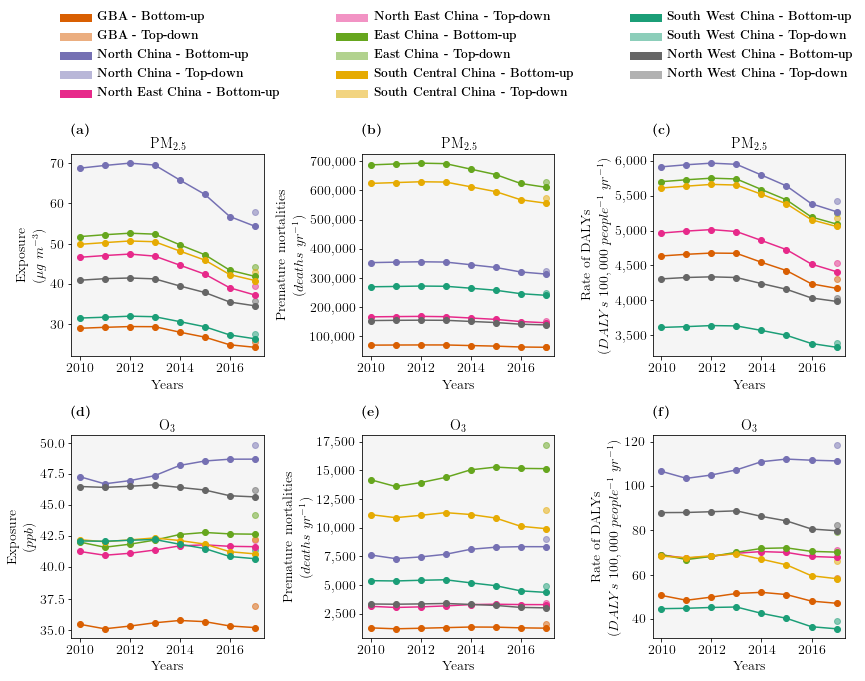

In [20]:
fig = plt.figure(1, figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)

make_plot(0, results_compare, regions_all[1:], 'PM2_5_DRY', 'exposure', 'Exposure\n(${\mu}g$ $m^{-3}$)', 'PM$_{2.5}$')
make_plot(1, results_compare, regions_all[1:], 'PM2_5_DRY', 'mort', 'Premature mortalities\n($deaths$ $yr^{-1}$)', 'PM$_{2.5}$')
make_plot(2, results_compare, regions_all[1:], 'PM2_5_DRY', 'dalys_rate', 'Rate of DALYs\n($DALYs$ $100,000$ $people^{-1}$ $yr^{-1}$)', 'PM$_{2.5}$')
make_plot(3, results_compare, regions_all[1:], 'o3_6mDM8h', 'exposure', 'Exposure\n($ppb$)', 'O$_{3}$')
make_plot(4, results_compare, regions_all[1:], 'o3_6mDM8h', 'mort', 'Premature mortalities\n($deaths$ $yr^{-1}$)', 'O$_{3}$')
make_plot(5, results_compare, regions_all[1:], 'o3_6mDM8h', 'dalys_rate', 'Rate of DALYs\n($DALYs$ $100,000$ $people^{-1}$ $yr^{-1}$)', 'O$_{3}$')

leg_1 = matplotlib.lines.Line2D([], [], color=region_colors['GBA'], linewidth=8.0, label=r'\textbf{GBA - Bottom-up}')
leg_2 = matplotlib.lines.Line2D([], [], color=region_colors['GBA'], linewidth=8.0, label=r'\textbf{GBA - Top-down}', alpha=0.5)
leg_3 = matplotlib.lines.Line2D([], [], color=region_colors['North China'], linewidth=8.0, label=r'\textbf{North China - Bottom-up}')
leg_4 = matplotlib.lines.Line2D([], [], color=region_colors['North China'], linewidth=8.0, label=r'\textbf{North China - Top-down}', alpha=0.5)
leg_5 = matplotlib.lines.Line2D([], [], color=region_colors['North East China'], linewidth=8.0, label=r'\textbf{North East China - Bottom-up}')
leg_6 = matplotlib.lines.Line2D([], [], color=region_colors['North East China'], linewidth=8.0, label=r'\textbf{North East China - Top-down}', alpha=0.5)
leg_7 = matplotlib.lines.Line2D([], [], color=region_colors['East China'], linewidth=8.0, label=r'\textbf{East China - Bottom-up}')
leg_8 = matplotlib.lines.Line2D([], [], color=region_colors['East China'], linewidth=8.0, label=r'\textbf{East China - Top-down}', alpha=0.5)
leg_9 = matplotlib.lines.Line2D([], [], color=region_colors['South Central China'], linewidth=8.0, label=r'\textbf{South Central China - Bottom-up}')
leg_10 = matplotlib.lines.Line2D([], [], color=region_colors['South Central China'], linewidth=8.0, label=r'\textbf{South Central China - Top-down}', alpha=0.5)
leg_11 = matplotlib.lines.Line2D([], [], color=region_colors['South West China'], linewidth=8.0, label=r'\textbf{South West China - Bottom-up}')
leg_12 = matplotlib.lines.Line2D([], [], color=region_colors['South West China'], linewidth=8.0, label=r'\textbf{South West China - Top-down}', alpha=0.5)
leg_13 = matplotlib.lines.Line2D([], [], color=region_colors['North West China'], linewidth=8.0, label=r'\textbf{North West China - Bottom-up}')
leg_14 = matplotlib.lines.Line2D([], [], color=region_colors['North West China'], linewidth=8.0, label=r'\textbf{North West China - Top-down}', alpha=0.5)

gs.tight_layout(fig, rect=[0, 0, 1, 1])

bb = (fig.subplotpars.left - 0.05, fig.subplotpars.top + 0.2, fig.subplotpars.right - fig.subplotpars.left + 0.15, 0.1)
plt.legend(
    fontsize=12, fancybox=True, loc='upper center', bbox_to_anchor=bb, ncol=3, frameon=False,
    handles=[leg_1, leg_2, leg_3, leg_4, leg_5, leg_6, leg_7, leg_8, leg_9, leg_10, leg_11, leg_12, leg_13, leg_14], mode='expand', borderaxespad=0., 
    bbox_transform=fig.transFigure
)

#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_trends_hia_regions_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_trends_hia_regions_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


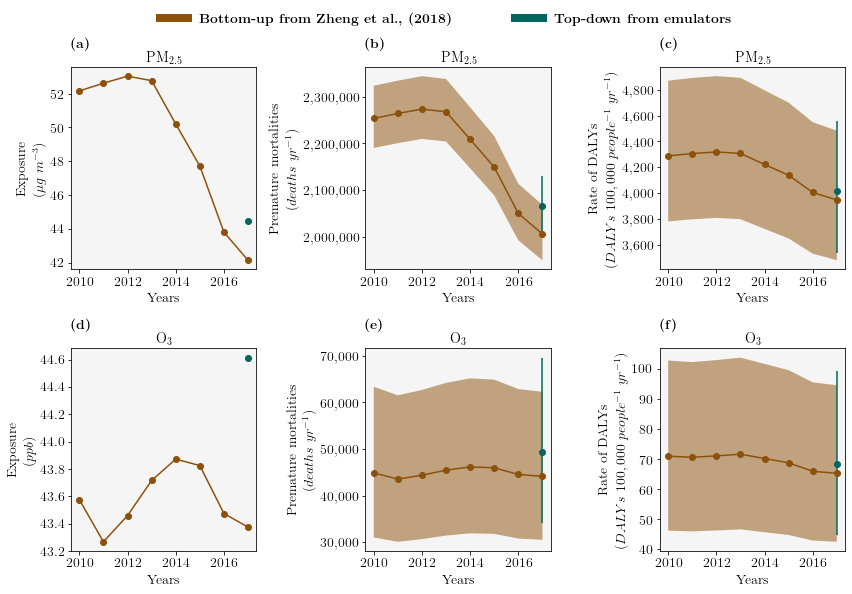

In [21]:
fig = plt.figure(1, figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)

make_plot(0, results_compare, ['China'], 'PM2_5_DRY', 'exposure', 'Exposure\n(${\mu}g$ $m^{-3}$)', 'PM$_{2.5}$')
make_plot(1, results_compare, ['China'], 'PM2_5_DRY', 'mort', 'Premature mortalities\n($deaths$ $yr^{-1}$)', 'PM$_{2.5}$')
make_plot(2, results_compare, ['China'], 'PM2_5_DRY', 'dalys_rate', 'Rate of DALYs\n($DALYs$ $100,000$ $people^{-1}$ $yr^{-1}$)', 'PM$_{2.5}$')
make_plot(3, results_compare, ['China'], 'o3_6mDM8h', 'exposure', 'Exposure\n($ppb$)', 'O$_{3}$')
make_plot(4, results_compare, ['China'], 'o3_6mDM8h', 'mort', 'Premature mortalities\n($deaths$ $yr^{-1}$)', 'O$_{3}$')
make_plot(5, results_compare, ['China'], 'o3_6mDM8h', 'dalys_rate', 'Rate of DALYs\n($DALYs$ $100,000$ $people^{-1}$ $yr^{-1}$)', 'O$_{3}$')

leg_1 = matplotlib.lines.Line2D([], [], color=region_colors['China'], linewidth=8.0, label=r'\textbf{Bottom-up from Zheng et al., (2018)}')
leg_2 = matplotlib.lines.Line2D([], [], color='#01665e', linewidth=8.0, label=r'\textbf{Top-down from emulators}')

gs.tight_layout(fig, rect=[0, 0, 1, 1])

bb = (fig.subplotpars.left + 0.06, fig.subplotpars.top + 0.05, fig.subplotpars.right - fig.subplotpars.left - 0.1, 0.1)
plt.legend(
    fontsize=14, fancybox=True, loc='upper center', bbox_to_anchor=bb, ncol=2, frameon=False,
    handles=[leg_1, leg_2], mode='expand', borderaxespad=0., 
    bbox_transform=fig.transFigure
)

#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_trends_hia_china_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_trends_hia_china_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [17]:
for output in ['PM2_5_DRY', 'o3_6mDM8h']:
    print(output)
    for outcome in ['mort']: # , 'dalys_rate' 
        print(outcome)
        for region in ['China']: # regions_all[0:1] for China, regions_all[1:] for without China
            print(region)
            mean_bottom_up_2010 = results_compare[region][output][outcome]['mean']['bottom_up_2010vs2015']
            mean_bottom_up_2011 = results_compare[region][output][outcome]['mean']['bottom_up_2011vs2015']
            mean_bottom_up_2012 = results_compare[region][output][outcome]['mean']['bottom_up_2012vs2015']
            mean_bottom_up_2013 = results_compare[region][output][outcome]['mean']['bottom_up_2013vs2015']
            mean_bottom_up_2014 = results_compare[region][output][outcome]['mean']['bottom_up_2014vs2015']
            mean_bottom_up_2015 = results_compare[region][output][outcome]['mean']['baseline']
            mean_bottom_up_2016 = results_compare[region][output][outcome]['mean']['bottom_up_2016vs2015']
            mean_bottom_up_2017 = results_compare[region][output][outcome]['mean']['bottom_up_2017vs2015']
            mean_top_down_2017 = results_compare[region][output][outcome]['mean']['top_down_2017vs2015']
            if outcome != 'exposure':
                lower_bottom_up_2010 = results_compare[region][output][outcome]['lower']['bottom_up_2010vs2015']
                upper_bottom_up_2010 = results_compare[region][output][outcome]['upper']['bottom_up_2010vs2015']
                lower_bottom_up_2011 = results_compare[region][output][outcome]['lower']['bottom_up_2011vs2015']
                upper_bottom_up_2011 = results_compare[region][output][outcome]['upper']['bottom_up_2011vs2015']
                lower_bottom_up_2012 = results_compare[region][output][outcome]['lower']['bottom_up_2012vs2015']
                upper_bottom_up_2012 = results_compare[region][output][outcome]['upper']['bottom_up_2012vs2015']
                lower_bottom_up_2013 = results_compare[region][output][outcome]['lower']['bottom_up_2013vs2015']
                upper_bottom_up_2013 = results_compare[region][output][outcome]['upper']['bottom_up_2013vs2015']
                lower_bottom_up_2014 = results_compare[region][output][outcome]['lower']['bottom_up_2014vs2015']
                upper_bottom_up_2014 = results_compare[region][output][outcome]['upper']['bottom_up_2014vs2015']
                lower_bottom_up_2015 = results_compare[region][output][outcome]['lower']['baseline']
                upper_bottom_up_2015 = results_compare[region][output][outcome]['upper']['baseline']
                lower_bottom_up_2016 = results_compare[region][output][outcome]['lower']['bottom_up_2016vs2015']
                upper_bottom_up_2016 = results_compare[region][output][outcome]['upper']['bottom_up_2016vs2015']
                lower_bottom_up_2017 = results_compare[region][output][outcome]['lower']['bottom_up_2017vs2015']
                upper_bottom_up_2017 = results_compare[region][output][outcome]['upper']['bottom_up_2017vs2015']
                lower_top_down_2017 = results_compare[region][output][outcome]['lower']['top_down_2017vs2015']
                upper_top_down_2017 = results_compare[region][output][outcome]['upper']['top_down_2017vs2015']


            if outcome == 'mort':
                round_to = -2
            if outcome == 'dalys_rate':
                round_to = 1
            
            #print(f"Bottom up 2010, {outcome} = {int(round(mean_bottom_up_2010, round_to)):,} (95UI: {int(round(lower_bottom_up_2010, round_to)):,} to {int(round(upper_bottom_up_2010, round_to)):,})")
            #print(f"Bottom up 2011, {outcome} = {int(round(mean_bottom_up_2011, round_to)):,} (95UI: {int(round(lower_bottom_up_2011, round_to)):,} to {int(round(upper_bottom_up_2011, round_to)):,})")
            print(f"Bottom up 2012, {outcome} = {int(round(mean_bottom_up_2012, round_to)):,} (95UI: {int(round(lower_bottom_up_2012, round_to)):,} to {int(round(upper_bottom_up_2012, round_to)):,})")
            #print(f"Bottom up 2013, {outcome} = {int(round(mean_bottom_up_2013, round_to)):,} (95UI: {int(round(lower_bottom_up_2013, round_to)):,} to {int(round(upper_bottom_up_2013, round_to)):,})")
            #print(f"Bottom up 2014, {outcome} = {int(round(mean_bottom_up_2014, round_to)):,} (95UI: {int(round(lower_bottom_up_2014, round_to)):,} to {int(round(upper_bottom_up_2014, round_to)):,})")
            print(f"Bottom up 2015, {outcome} = {int(round(mean_bottom_up_2015, round_to)):,} (95UI: {int(round(lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2015, round_to)):,})")
            #print(f"Bottom up 2016, {outcome} = {int(round(mean_bottom_up_2016, round_to)):,} (95UI: {int(round(lower_bottom_up_2016, round_to)):,} to {int(round(upper_bottom_up_2016, round_to)):,})")
            print(f"Bottom up 2017, {outcome} = {int(round(mean_bottom_up_2017, round_to)):,} (95UI: {int(round(lower_bottom_up_2017, round_to)):,} to {int(round(upper_bottom_up_2017, round_to)):,})")
            #print(f"Top down  2017, {outcome} = {int(round(mean_top_down_2017, round_to)):,} (95UI: {int(round(lower_top_down_2017, round_to)):,} to {int(round(upper_top_down_2017, round_to)):,})")
            
            #print(f"Bottom up 2010 vs 2015, {outcome} reduction of = {int(round(mean_bottom_up_2010 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_bottom_up_2010 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2010 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_bottom_up_2010 / mean_bottom_up_2015) - 1), 0))}%")
            #print(f"Bottom up 2011 vs 2015, {outcome} reduction of = {int(round(mean_bottom_up_2011 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_bottom_up_2011 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2011 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_bottom_up_2011 / mean_bottom_up_2015) - 1), 0))}%")
            print(f"Bottom up 2012 vs 2015, {outcome} reduction of = {int(round(mean_bottom_up_2012 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_bottom_up_2012 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2012 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_bottom_up_2012 / mean_bottom_up_2015) - 1), 0))}%")
            #print(f"Bottom up 2013 vs 2015, {outcome} reduction of = {int(round(mean_bottom_up_2013 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_bottom_up_2013 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2013 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_bottom_up_2013 / mean_bottom_up_2015) - 1), 0))}%")
            #print(f"Bottom up 2014 vs 2015, {outcome} reduction of = {int(round(mean_bottom_up_2014 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_bottom_up_2014 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2014 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_bottom_up_2014 / mean_bottom_up_2015) - 1), 0))}%")
            #print(f"Bottom up 2016 vs 2015, {outcome} reduction of = {int(round(mean_bottom_up_2016 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_bottom_up_2016 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2016 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_bottom_up_2016 / mean_bottom_up_2015) - 1), 0))}%")
            print(f"Bottom up 2017 vs 2015, {outcome} reduction of = {int(round(mean_bottom_up_2017 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_bottom_up_2017 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_bottom_up_2017 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_bottom_up_2017 / mean_bottom_up_2015) - 1), 0))}%")
            #print(f"Top down  2017 vs 2015, {outcome} reduction of = {int(round(mean_top_down_2017 - mean_bottom_up_2015, round_to)):,} ({int(round(lower_top_down_2017 - lower_bottom_up_2015, round_to)):,} to {int(round(upper_top_down_2017 - upper_bottom_up_2015, round_to)):,}), {int(round(100 * ((mean_top_down_2017 / mean_bottom_up_2015) - 1), 0))}%")
            #print(f"Top down vs bottom up, {outcome} reduction of = {int(round(mean_top_down_2017 - mean_bottom_up_2017, round_to)):,} ({int(round(lower_top_down_2017 - lower_bottom_up_2017, round_to)):,} to {int(round(upper_top_down_2017 - upper_bottom_up_2017, round_to)):,}), {int(round(100 * ((mean_top_down_2017 / mean_bottom_up_2017) - 1), 0))}%")
            print()

PM2_5_DRY
mort
China
Bottom up 2012, mort = 2,273,400 (95UI: 2,209,600 to 2,343,900)
Bottom up 2015, mort = 2,149,000 (95UI: 2,088,600 to 2,215,600)
Bottom up 2017, mort = 2,006,100 (95UI: 1,949,800 to 2,068,400)
Bottom up 2012 vs 2015, mort reduction of = 124,400 (121,000 to 128,300), 6%
Bottom up 2017 vs 2015, mort reduction of = -142,800 (-138,800 to -147,300), -7%

o3_6mDM8h
mort
China
Bottom up 2012, mort = 44,400 (95UI: 30,700 to 62,600)
Bottom up 2015, mort = 46,000 (95UI: 31,800 to 64,900)
Bottom up 2017, mort = 44,100 (95UI: 30,500 to 62,300)
Bottom up 2012 vs 2015, mort reduction of = -1,600 (-1,100 to -2,200), -3%
Bottom up 2017 vs 2015, mort reduction of = -1,800 (-1,300 to -2,600), -4%



In [16]:
for output in ['PM2_5_DRY', 'o3_6mDM8h']:
    print(output)
    for outcome in ['exposure']:
        print(outcome)
        for region in ['China']: # regions_all[0:1] for China, regions_all[1:] for without China
            print(region)
            mean_bottom_up_2010 = results_compare[region][output][outcome]['mean']['bottom_up_2010vs2015']
            mean_bottom_up_2011 = results_compare[region][output][outcome]['mean']['bottom_up_2011vs2015']
            mean_bottom_up_2012 = results_compare[region][output][outcome]['mean']['bottom_up_2012vs2015']
            mean_bottom_up_2013 = results_compare[region][output][outcome]['mean']['bottom_up_2013vs2015']
            mean_bottom_up_2014 = results_compare[region][output][outcome]['mean']['bottom_up_2014vs2015']
            mean_bottom_up_2015 = results_compare[region][output][outcome]['mean']['baseline']
            mean_bottom_up_2016 = results_compare[region][output][outcome]['mean']['bottom_up_2016vs2015']
            mean_bottom_up_2017 = results_compare[region][output][outcome]['mean']['bottom_up_2017vs2015']
            mean_top_down_2017 = results_compare[region][output][outcome]['mean']['top_down_2017vs2015']
            round_to = 1
            #print(f"Bottom up 2010, {outcome} = {round(mean_bottom_up_2010, round_to):,}")
            #print(f"Bottom up 2011, {outcome} = {round(mean_bottom_up_2011, round_to):,}")
            print(f"Bottom up 2012, {outcome} = {round(mean_bottom_up_2012, round_to):,}")
            #print(f"Bottom up 2013, {outcome} = {round(mean_bottom_up_2013, round_to):,}")
            #print(f"Bottom up 2014, {outcome} = {round(mean_bottom_up_2014, round_to):,}")
            print(f"Bottom up 2015, {outcome} = {round(mean_bottom_up_2015, round_to):,}")
            #print(f"Bottom up 2016, {outcome} = {round(mean_bottom_up_2016, round_to):,}")
            print(f"Bottom up 2017, {outcome} = {round(mean_bottom_up_2017, round_to):,}")
            #print(f"Top down  2017, {outcome} = {round(mean_top_down_2017, round_to):,}")
            
            #print(f"Bottom up 2010 vs 2015, {outcome} reduction of = {round(mean_bottom_up_2010 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_bottom_up_2010 / mean_bottom_up_2015) - 1), 0)}%")
            #print(f"Bottom up 2011 vs 2015, {outcome} reduction of = {round(mean_bottom_up_2011 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_bottom_up_2011 / mean_bottom_up_2015) - 1), 0)}%")
            print(f"Bottom up 2012 vs 2015, {outcome} reduction of = {round(mean_bottom_up_2012 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_bottom_up_2012 / mean_bottom_up_2015) - 1), 0)}%")
            #print(f"Bottom up 2013 vs 2015, {outcome} reduction of = {round(mean_bottom_up_2013 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_bottom_up_2013 / mean_bottom_up_2015) - 1), 0)}%")
            #print(f"Bottom up 2014 vs 2015, {outcome} reduction of = {round(mean_bottom_up_2014 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_bottom_up_2014 / mean_bottom_up_2015) - 1), 0)}%")
            #print(f"Bottom up 2016 vs 2015, {outcome} reduction of = {round(mean_bottom_up_2016 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_bottom_up_2016 / mean_bottom_up_2015) - 1), 0)}%")
            print(f"Bottom up 2017 vs 2015, {outcome} reduction of = {round(mean_bottom_up_2017 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_bottom_up_2017 / mean_bottom_up_2015) - 1), 0)}%")
            #print(f"Top down  2017 vs 2015, {outcome} reduction of = {round(mean_top_down_2017 - mean_bottom_up_2015, round_to):,}, {round(100 * ((mean_top_down_2017 / mean_bottom_up_2015) - 1), 0)}%")
            
            #print(f"Top down vs bottom up, {outcome} reduction of = {round(mean_top_down_2017 - mean_bottom_up_2017, round_to):,}, {round(100 * ((mean_top_down_2017 / mean_bottom_up_2017) - 1), 0)}%")
            print()

PM2_5_DRY
exposure
China
Bottom up 2012, exposure = 53.0
Bottom up 2015, exposure = 47.7
Bottom up 2017, exposure = 42.1
Bottom up 2012 vs 2015, exposure reduction of = 5.3, 11.0%
Bottom up 2017 vs 2015, exposure reduction of = -5.6, -12.0%

o3_6mDM8h
exposure
China
Bottom up 2012, exposure = 43.5
Bottom up 2015, exposure = 43.8
Bottom up 2017, exposure = 43.4
Bottom up 2012 vs 2015, exposure reduction of = -0.4, -1.0%
Bottom up 2017 vs 2015, exposure reduction of = -0.4, -1.0%



In [15]:
df = pd.read_csv('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator_annual/health_impact_assessments/PM2_5_DRY_scaled/df_country_hia_PM2_5_DRY_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_scaled.csv')
df

,Unnamed: 0,name,pop,pm25_popweighted,mort_ncdlri_mean_total,mort_ncdlri_upper_total,mort_ncdlri_lower_total,dalys_ncdlri_mean_total,dalys_ncdlri_upper_total,dalys_ncdlri_lower_total,mort_rate_ncdlri_mean_total,mort_rate_ncdlri_upper_total,mort_rate_ncdlri_lower_total,dalys_rate_ncdlri_mean_total,dalys_rate_ncdlri_upper_total,dalys_rate_ncdlri_lower_total
0,0,China,1.347615e+09,47.713142,2.148987e+06,2.215627e+06,2.088637e+06,7.179213e+07,8.153834e+07,6.331298e+07,123.442978,127.272432,119.974240,4137.344282,4699.755582,3648.078600
1,1,Hong Kong,6.236073e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Macao,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Taiwan,2.077025e+07,6.987705,7.133305e+03,7.254995e+03,7.014371e+03,2.510353e+05,2.861642e+05,2.202735e+05,76.862420,78.173955,75.580632,2708.283799,3087.418574,2376.292959


In [24]:
RES = [115, 119, 120, 113, 106, 100, 92, 84]
IND = [127, 130, 130, 129, 112, 100, 84, 81]
TRA = [98, 101, 101, 102, 99, 100, 97, 99]
AGR = [98, 101, 102, 101, 101, 100, 99, 99]
ENE = [136, 146, 139, 129, 112, 100, 94, 89]

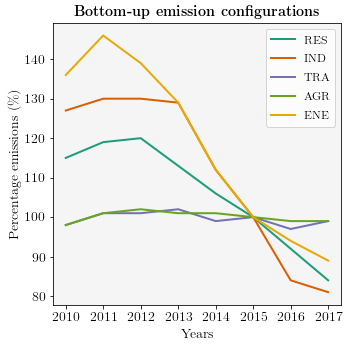

In [25]:
fig = plt.figure(1, figsize=(5, 5))
gs = gridspec.GridSpec(1, 1)

ax = fig.add_subplot(gs[0])
ax.set_facecolor('whitesmoke')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Percentage emissions ({\%})', fontsize=14)
plt.title(r'\textbf{Bottom-up emission configurations}')
plt.plot(years, RES, linewidth=2, color='#1b9e77', label='RES')
plt.plot(years, IND, linewidth=2, color='#d95f02', label='IND')
plt.plot(years, TRA, linewidth=2, color='#7570b3', label='TRA')
plt.plot(years, AGR, linewidth=2, color='#66a61e', label='AGR')
plt.plot(years, ENE, linewidth=2, color='#e6ab02', label='ENE')
plt.legend()
gs.tight_layout(fig, rect=[0, 0, 1, 1])

#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_trends_configs_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_trends_configs_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [27]:
def make_plot(index, letter, results_compare, regions, output, outcome, label, title):
    ax = fig.add_subplot(gs[index])
    plt.annotate(r'\textbf{(' + letter + ')}', xy=(0, 1.1), xycoords='axes fraction', fontsize=14)
    ax.set_facecolor('whitesmoke')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if outcome != 'exposure':
        ax.get_yaxis().set_major_formatter(comma_format)
    plt.xlabel('Years', fontsize=14)
    plt.ylabel(label, fontsize=14)
    plt.title(title)
    for region in regions:
        means = []
        lowers = []
        uppers = []
        for year in years:
            if year == 2015:
                run = 'baseline'
            else:
                run = f'bottom_up_{year}vs2015'
            means.append(results_compare[region][output][outcome]['mean'][run])
            if outcome != 'exposure':
                lowers.append(results_compare[region][output][outcome]['lower'][run])
                uppers.append(results_compare[region][output][outcome]['upper'][run])

        plt.plot(years, means, color=region_colors[region], marker='o')
        if region != 'China':
            plt.scatter(2017, results_compare[region][output][outcome]['mean']['top_down_2017vs2015'], color=region_colors[region], alpha=0.5)
    if region == 'China':
        if outcome != 'exposure':
            plt.fill_between(years, lowers, uppers, facecolor=region_colors[region], alpha=0.5)
            plt.errorbar(
                2017, results_compare[region][output][outcome]['mean']['top_down_2017vs2015'], 
                yerr=np.array([[
                    results_compare[region][output][outcome]['mean']['top_down_2017vs2015'] - results_compare[region][output][outcome]['lower']['top_down_2017vs2015'], 
                    results_compare[region][output][outcome]['upper']['top_down_2017vs2015'] - results_compare[region][output][outcome]['mean']['top_down_2017vs2015']
                ]]).T, color='#01665e', fmt='o')
        else:
            plt.scatter(2017, results_compare[region][output][outcome]['mean']['top_down_2017vs2015'], color='#01665e')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


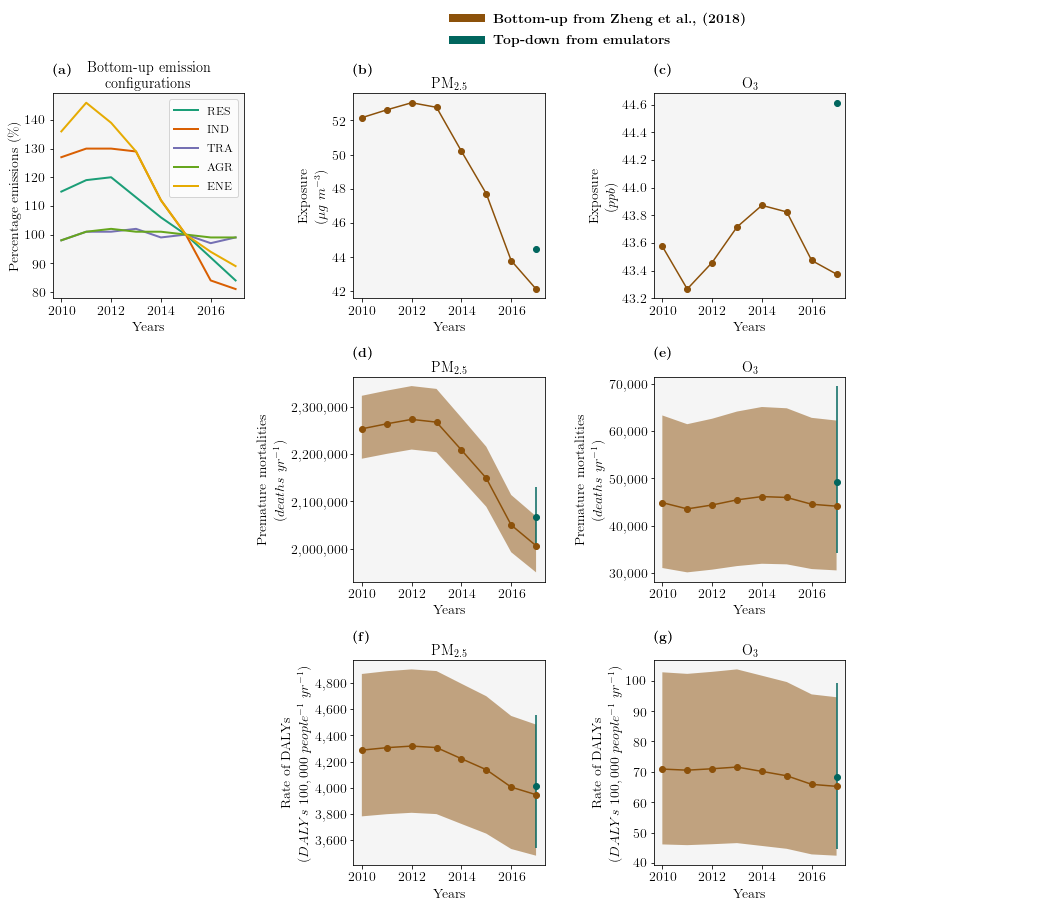

In [29]:
fig = plt.figure(1, figsize=(12, 12))
gs = gridspec.GridSpec(3, 3)

ax = fig.add_subplot(gs[0])
ax.set_facecolor('whitesmoke')
plt.annotate(r'\textbf{(a)}', xy=(0, 1.1), xycoords='axes fraction', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Percentage emissions ({\%})', fontsize=14)
plt.title('Bottom-up emission\nconfigurations')
plt.plot(years, RES, linewidth=2, color='#1b9e77', label='RES')
plt.plot(years, IND, linewidth=2, color='#d95f02', label='IND')
plt.plot(years, TRA, linewidth=2, color='#7570b3', label='TRA')
plt.plot(years, AGR, linewidth=2, color='#66a61e', label='AGR')
plt.plot(years, ENE, linewidth=2, color='#e6ab02', label='ENE')
plt.legend()

make_plot(1, 'b', results_compare, ['China'], 'PM2_5_DRY', 'exposure', 'Exposure\n(${\mu}g$ $m^{-3}$)', 'PM$_{2.5}$')
make_plot(2, 'c', results_compare, ['China'], 'o3_6mDM8h', 'exposure', 'Exposure\n($ppb$)', 'O$_{3}$')
make_plot(4, 'd', results_compare, ['China'], 'PM2_5_DRY', 'mort', 'Premature mortalities\n($deaths$ $yr^{-1}$)', 'PM$_{2.5}$')
make_plot(5, 'e', results_compare, ['China'], 'o3_6mDM8h', 'mort', 'Premature mortalities\n($deaths$ $yr^{-1}$)', 'O$_{3}$')
make_plot(7, 'f', results_compare, ['China'], 'PM2_5_DRY', 'dalys_rate', 'Rate of DALYs\n($DALYs$ $100,000$ $people^{-1}$ $yr^{-1}$)', 'PM$_{2.5}$')
make_plot(8, 'g', results_compare, ['China'], 'o3_6mDM8h', 'dalys_rate', 'Rate of DALYs\n($DALYs$ $100,000$ $people^{-1}$ $yr^{-1}$)', 'O$_{3}$')

leg_1 = matplotlib.lines.Line2D([], [], color=region_colors['China'], linewidth=8.0, label=r'\textbf{Bottom-up from Zheng et al., (2018)}')
leg_2 = matplotlib.lines.Line2D([], [], color='#01665e', linewidth=8.0, label=r'\textbf{Top-down from emulators}')

gs.tight_layout(fig, rect=[0, 0, 1, 1])

bb = (fig.subplotpars.left + 0.4, fig.subplotpars.top + 0.07, fig.subplotpars.right - fig.subplotpars.left - 0.1, 0.1)
plt.legend(
    fontsize=14, fancybox=True, loc='upper center', bbox_to_anchor=bb, ncol=1, frameon=False,
    handles=[leg_1, leg_2], mode='expand', borderaxespad=0., 
    bbox_transform=fig.transFigure
)

plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_trends_hia_china_with_configs_scaled.png', dpi=700, alpha=True, bbox_inches='tight')
plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator_annual/emission_trends_hia_china_with_configs_scaled.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()